Note that Prophet currently requires Python 3.5, so we cannot use f-strings.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

passengers = pd.read_csv('../examples/MonthlyFlights/AirPassengers.csv')
passengers.columns = ['date', 'passengers']
passengers['date'] = pd.to_datetime(passengers['date'])
passengers.set_index('date', inplace = True)
passengers.head()



,passengers
date,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


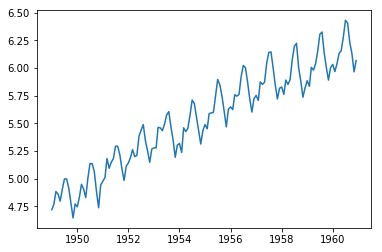

In [4]:
log_passengers = np.log(passengers['passengers'])


plt.plot(log_passengers);

In [5]:
def find_differencing_order(s):
    s_copy = s.copy()
    std_old = float('inf')
    count = 0
    while True:
        std_curr = s_copy.std()
        print('Std dev after {count:02d} differences = {std_curr:8.6f}'.format(count = count, std_curr=std_curr))
        if std_curr > std_old:
            return count - 1
        s_copy = s_copy.diff()
        std_old = std_curr
        count += 1
        
find_differencing_order(log_passengers)

Std dev after 00 differences = 0.441456
Std dev after 01 differences = 0.106556
Std dev after 02 differences = 0.135008


1

## Finding p and q

In [6]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

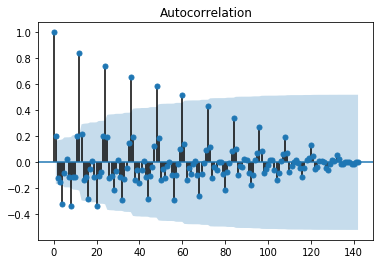

In [7]:
plot_acf(log_passengers.diff()[1:]);

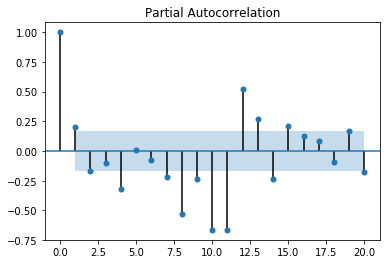

In [8]:
plot_pacf(log_passengers.diff()[2:], lags=20);

In [9]:
model = ARIMA(log_passengers, order=(2,1,2))
model_fit = model.fit()

/anaconda3/lib/python3.5/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.5/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [10]:
#predictions_ARIMA =pd.Series(, index=log_passengers.index)
predictions_ARIMA = pd.Series(log_passengers + model_fit.predict(start=1, end=200))
predictions_ARIMA.head()

1949-01-01         NaN
1949-02-01    4.780265
1949-03-01    4.900293
1949-04-01    4.887483
1949-05-01    4.791270
dtype: float64

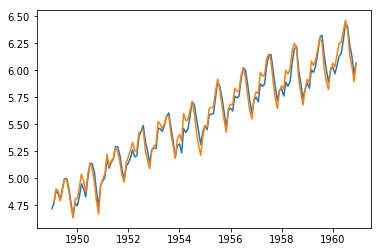

In [11]:
plt.plot(log_passengers)
plt.plot(predictions_ARIMA)

## Levels

When calling `model_fit.predict` it will (by default) give the difference from the lag1 value (i.e. the differenced value). To recover the actual prediction, use the keyword argument `typ='levels'`. This is the same as adding the original series with one lag (as shown in the cell below).

We also have the option of doing `dynamic=True`. This change says "use the _prediction_ of the lag one timestep as input to the forecast, rather than the actual value (what you get with `dynamic=False`)." This enables us to simulate doing long term forecasts.

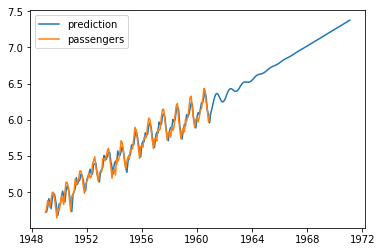

In [12]:

level_prediction = model_fit.predict(start=1, end=265, typ='levels')

plt.plot(level_prediction, label='prediction')
plt.plot(log_passengers, label='passengers')
plt.legend()


In [13]:
(level_prediction - (log_passengers.shift(1) + model_fit.predict(start=1, end=200))).head()

1949-01-01    NaN
1949-02-01    0.0
1949-03-01    0.0
1949-04-01    0.0
1949-05-01    0.0
dtype: float64

<Figure size 1200x800 with 0 Axes>

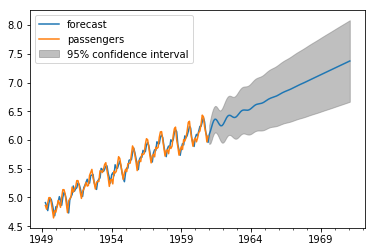

In [14]:
plt.figure(dpi=200)
model_fit.plot_predict(3,265);

## Fourier series analysis

In [15]:
power = np.abs(np.fft.fft(log_passengers.diff()[1:]))**2

In [16]:
1/np.fft.fftfreq(power.shape[0])

/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.


array([          inf,  143.        ,   71.5       ,   47.66666667,
         35.75      ,   28.6       ,   23.83333333,   20.42857143,
         17.875     ,   15.88888889,   14.3       ,   13.        ,
         11.91666667,   11.        ,   10.21428571,    9.53333333,
          8.9375    ,    8.41176471,    7.94444444,    7.52631579,
          7.15      ,    6.80952381,    6.5       ,    6.2173913 ,
          5.95833333,    5.72      ,    5.5       ,    5.2962963 ,
          5.10714286,    4.93103448,    4.76666667,    4.61290323,
          4.46875   ,    4.33333333,    4.20588235,    4.08571429,
          3.97222222,    3.86486486,    3.76315789,    3.66666667,
          3.575     ,    3.48780488,    3.4047619 ,    3.3255814 ,
          3.25      ,    3.17777778,    3.10869565,    3.04255319,
          2.97916667,    2.91836735,    2.86      ,    2.80392157,
          2.75      ,    2.69811321,    2.64814815,    2.6       ,
          2.55357143,    2.50877193,    2.46551724,    2.42372

In [17]:
power[1:power.shape[0]//2]

array([3.03033257e-02, 1.57613037e-02, 1.31375071e-01, 1.11371996e-02,
       7.15073474e-02, 5.57489203e-02, 8.45824994e-03, 9.45776874e-02,
       2.10211085e-02, 1.14769089e-01, 1.32218719e+00, 2.97329847e+01,
       8.28192225e-01, 3.63052623e-01, 1.34763413e-02, 6.88856752e-03,
       5.97688810e-02, 4.56018925e-01, 1.81686213e-01, 2.77002627e-02,
       9.25143909e-02, 2.20386166e-01, 1.51726625e-01, 3.46143961e+01,
       5.04728217e-01, 2.96510478e-01, 1.34764371e-01, 2.22070353e-02,
       1.02897458e-01, 8.38566934e-02, 1.27312629e-01, 8.46190183e-01,
       5.77504294e-01, 4.21976241e-01, 1.49587293e+00, 5.87853057e+00,
       7.22517023e-02, 2.27411462e-01, 9.11095002e-02, 1.18457004e-01,
       1.39054289e-01, 2.96675433e-03, 8.31694478e-02, 3.07937282e-01,
       5.48728984e-01, 6.27755003e-01, 7.28737224e+00, 9.17379261e+00,
       3.50766903e-01, 1.26442843e+00, 4.58518080e-01, 9.06247477e-02,
       5.70416127e-02, 5.35346654e-02, 5.15481353e-01, 1.56034123e-01,
      

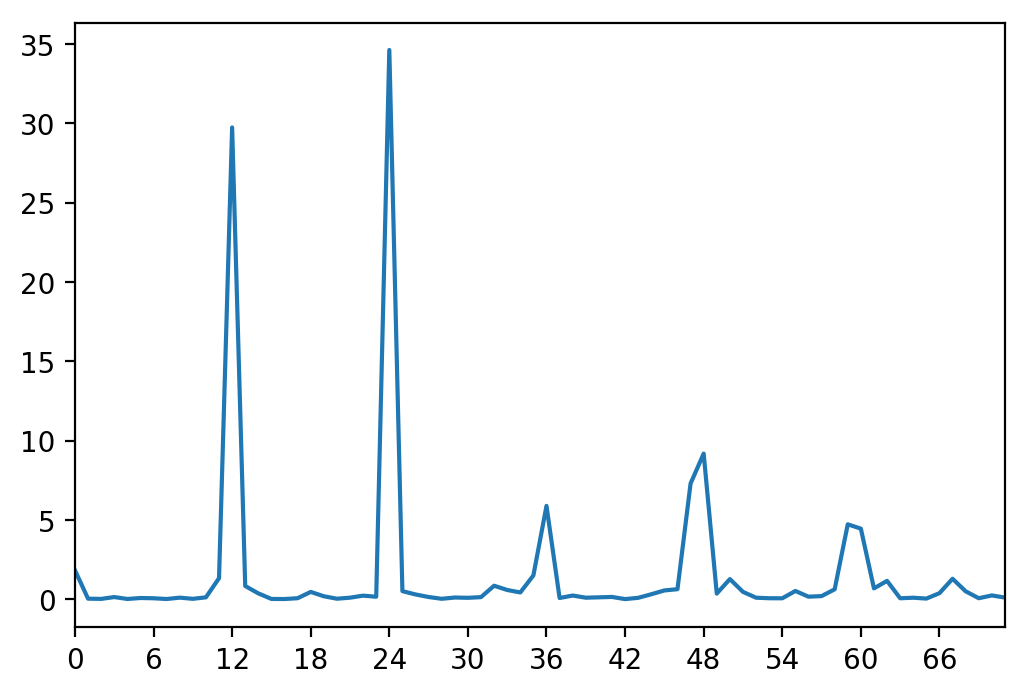

In [18]:
plt.figure(dpi=200)
plt.plot(power)
plt.xlim(0,71)
plt.xticks(range(0,72,6));

Shows strong signs of only having a strong response at 6 months (freq = 24), 12 months (freq = 12) and 3 months (freq = 36). So far we have only implemented the AR, I and MA pieces. Do these frequencies still show up in the residuals?

In [19]:
power_resid = np.abs(np.fft.fft(model_fit.resid))**2

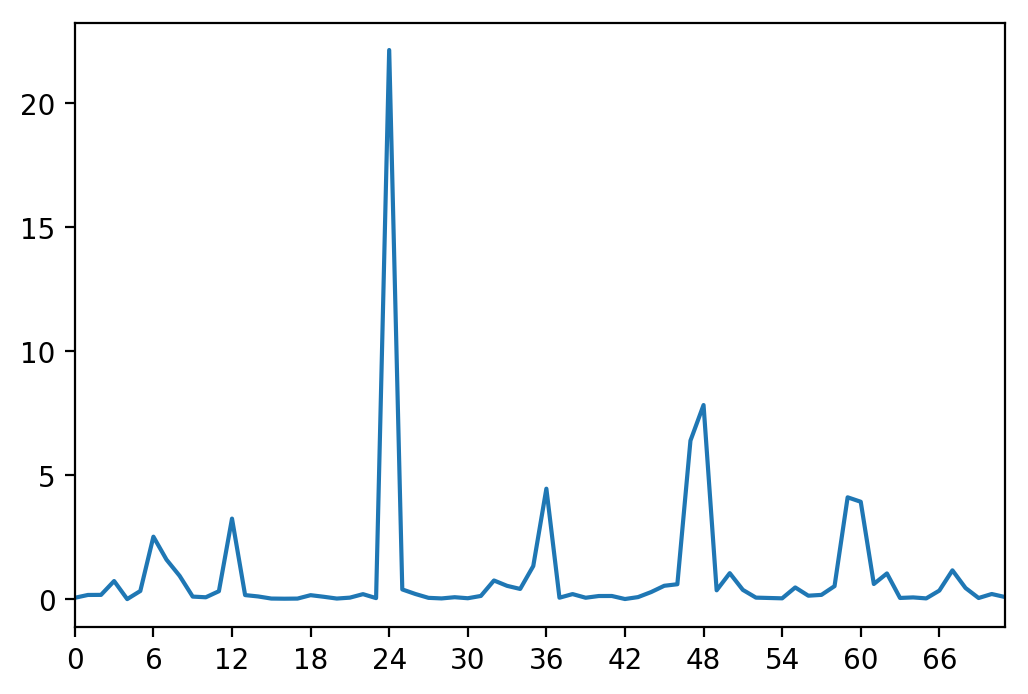

In [20]:
plt.figure(dpi=200)
plt.plot(power_resid)
plt.xlim(0,71)
plt.xticks(range(0,72,6));

In [21]:
# which month gaps are showing strong signals?
1/np.fft.fftfreq(power_resid.shape[0])[[6,12,24,36,48]]

array([23.83333333, 11.91666667,  5.95833333,  3.97222222,  2.97916667])

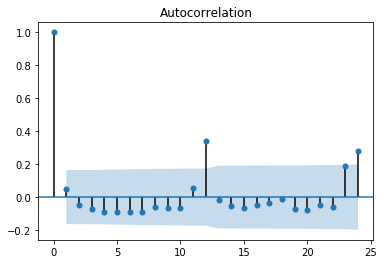

In [22]:
plot_acf(power_resid, lags=24);

## Compare to Prophet

In [23]:
from fbprophet import Prophet

Prophet insists that the thing to predict is called `y`, and the time column (not index) is called `ds`

In [24]:
prophet_passengers = log_passengers.reset_index().rename(columns = {'date': 'ds', 'passengers': 'y'})

In [25]:
my_model = Prophet(interval_width=0.95)

In [26]:
my_model.fit(prophet_passengers)

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/anaconda3/lib/python3.5/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [27]:
future_dates = my_model.make_future_dataframe(periods=36, freq='MS')
future_dates.tail()

,ds
175,1963-08-01
176,1963-09-01
177,1963-10-01
178,1963-11-01
179,1963-12-01


In [28]:
forecast = my_model.predict(future_dates)

In [29]:
forecast

,ds,trend,trend_lower,trend_upper,yhat_lower,yhat_upper,additive_terms,additive_terms_lower,additive_terms_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yearly,yearly_lower,yearly_upper,yhat
0,1949-01-01,4.801629,4.801629,4.801629,4.642881,4.782512,-0.088907,-0.088907,-0.088907,0.0,0.0,0.0,-0.088907,-0.088907,-0.088907,4.712722
1,1949-02-01,4.807215,4.807215,4.807215,4.634877,4.775467,-0.100567,-0.100567,-0.100567,0.0,0.0,0.0,-0.100567,-0.100567,-0.100567,4.706648
2,1949-03-01,4.812261,4.812261,4.812261,4.764439,4.909323,0.021930,0.021930,0.021930,0.0,0.0,0.0,0.021930,0.021930,0.021930,4.834191
3,1949-04-01,4.817847,4.817847,4.817847,4.754114,4.883805,-0.002407,-0.002407,-0.002407,0.0,0.0,0.0,-0.002407,-0.002407,-0.002407,4.815440
4,1949-05-01,4.823253,4.823253,4.823253,4.737607,4.892470,-0.008918,-0.008918,-0.008918,0.0,0.0,0.0,-0.008918,-0.008918,-0.008918,4.814335
5,1949-06-01,4.828839,4.828839,4.828839,4.881607,5.017552,0.118880,0.118880,0.118880,0.0,0.0,0.0,0.118880,0.118880,0.118880,4.947719
6,1949-07-01,4.834245,4.834245,4.834245,4.978149,5.120480,0.216555,0.216555,0.216555,0.0,0.0,0.0,0.216555,0.216555,0.216555,5.050800
7,1949-08-01,4.839831,4.839831,4.839831,4.981511,5.118881,0.209993,0.209993,0.209993,0.0,0.0,0.0,0.209993,0.209993,0.209993,5.049825
8,1949-09-01,4.845417,4.845417,4.845417,4.835390,4.977885,0.063286,0.063286,0.063286,0.0,0.0,0.0,0.063286,0.063286,0.063286,4.908703
9,1949-10-01,4.850823,4.850823,4.850823,4.718232,4.849560,-0.070526,-0.070526,-0.070526,0.0,0.0,0.0,-0.070526,-0.070526,-0.070526,4.780297


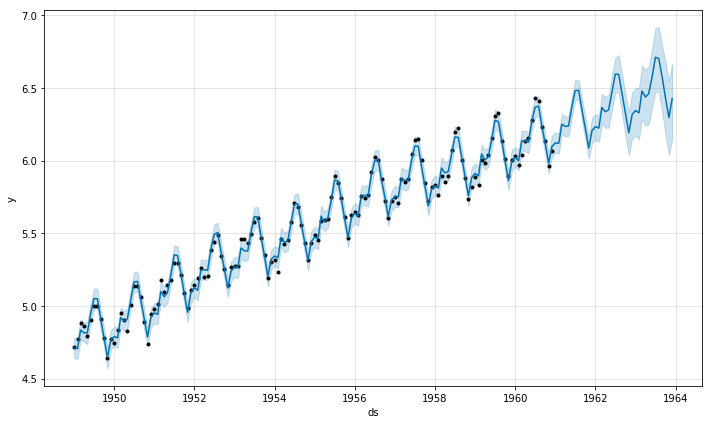

In [30]:
my_model.plot(forecast, uncertainty=True);

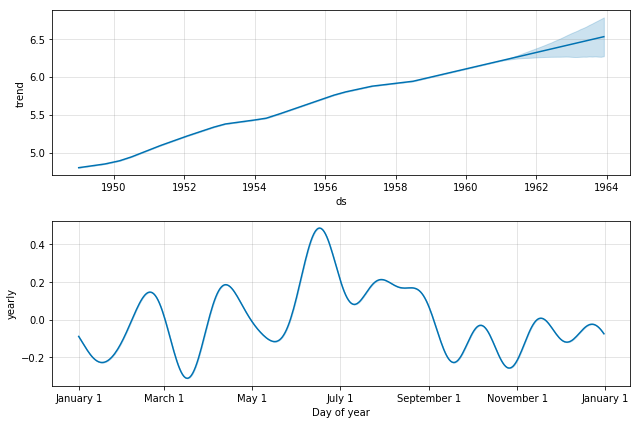

In [31]:
my_model.plot_components(forecast);

In [32]:
my_model.performance_metrics(forecast)

AttributeError: 'Prophet' object has no attribute 'performance_metrics'

In [33]:
import fbprophet
    
dir(fbprophet.diagnostics)

['__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'coverage',
 'cross_validation',
 'deepcopy',
 'generate_cutoffs',
 'logger',
 'logging',
 'mae',
 'mape',
 'mse',
 'np',
 'pd',
 'performance_metrics',
 'prophet_copy',
 'reduce',
 'rmse',
 'rolling_mean']

In [34]:
fbprophet.diagnostics.performance_metrics(prophet_passengers, rolling_window=0.2)

KeyError: 'cutoff'

In [35]:
forecast

,ds,trend,trend_lower,trend_upper,yhat_lower,yhat_upper,additive_terms,additive_terms_lower,additive_terms_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yearly,yearly_lower,yearly_upper,yhat
0,1949-01-01,4.801629,4.801629,4.801629,4.642881,4.782512,-0.088907,-0.088907,-0.088907,0.0,0.0,0.0,-0.088907,-0.088907,-0.088907,4.712722
1,1949-02-01,4.807215,4.807215,4.807215,4.634877,4.775467,-0.100567,-0.100567,-0.100567,0.0,0.0,0.0,-0.100567,-0.100567,-0.100567,4.706648
2,1949-03-01,4.812261,4.812261,4.812261,4.764439,4.909323,0.021930,0.021930,0.021930,0.0,0.0,0.0,0.021930,0.021930,0.021930,4.834191
3,1949-04-01,4.817847,4.817847,4.817847,4.754114,4.883805,-0.002407,-0.002407,-0.002407,0.0,0.0,0.0,-0.002407,-0.002407,-0.002407,4.815440
4,1949-05-01,4.823253,4.823253,4.823253,4.737607,4.892470,-0.008918,-0.008918,-0.008918,0.0,0.0,0.0,-0.008918,-0.008918,-0.008918,4.814335
5,1949-06-01,4.828839,4.828839,4.828839,4.881607,5.017552,0.118880,0.118880,0.118880,0.0,0.0,0.0,0.118880,0.118880,0.118880,4.947719
6,1949-07-01,4.834245,4.834245,4.834245,4.978149,5.120480,0.216555,0.216555,0.216555,0.0,0.0,0.0,0.216555,0.216555,0.216555,5.050800
7,1949-08-01,4.839831,4.839831,4.839831,4.981511,5.118881,0.209993,0.209993,0.209993,0.0,0.0,0.0,0.209993,0.209993,0.209993,5.049825
8,1949-09-01,4.845417,4.845417,4.845417,4.835390,4.977885,0.063286,0.063286,0.063286,0.0,0.0,0.0,0.063286,0.063286,0.063286,4.908703
9,1949-10-01,4.850823,4.850823,4.850823,4.718232,4.849560,-0.070526,-0.070526,-0.070526,0.0,0.0,0.0,-0.070526,-0.070526,-0.070526,4.780297


In [36]:
fbprophet.diagnostics.cross_validation(my_model, initial='365 days', horizon='12 M')

INFO:fbprophet.diagnostics:Making 131 forecasts with cutoffs between 1950-01-31 23:48:00 and 1960-11-30 23:48:00
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 9.0.
/anaconda3/lib/python3.5/site-packages/fbprophet/forecaster.py:353: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  np.linspace(0, hist_size - 1, self.n_changepoints + 1)
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 10.0.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 11.0.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 11.0.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 12.0.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 13.0.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 14.0.
INFO:fbprophet.forecaster:n_changepoi

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,1950-02-01,10.160787,10.160232,10.161377,4.836282,1950-01-31 23:48:00
1,1950-03-01,4.333099,4.115954,4.506879,4.948760,1950-02-28 23:48:00
2,1950-04-01,4.517453,4.405132,4.653562,4.905275,1950-03-31 23:48:00
3,1950-05-01,4.849003,4.843580,4.853724,4.828314,1950-04-30 23:48:00
4,1950-06-01,5.216855,5.207475,5.224839,5.003946,1950-05-31 23:48:00
5,1950-07-01,5.238079,5.225614,5.248226,5.135798,1950-06-30 23:48:00
6,1950-08-01,4.906288,4.890582,4.921832,5.135798,1950-07-31 23:48:00
7,1950-09-01,5.020351,5.016742,5.024261,5.062595,1950-08-31 23:48:00
8,1950-10-01,4.846044,4.837257,4.855109,4.890349,1950-09-30 23:48:00
9,1950-11-01,4.753409,4.750712,4.756203,4.736198,1950-10-31 23:48:00
